In [ ]:
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.datamodel.base_models import InputFormat
from docling.datamodel.document import DoclingDocument
from docling.document_converter import PdfFormatOption , DocumentConverter
import fitz

# Convert a document
The first thing that we want to do  is to take our original document , here it is a pdf document and convert it to **DoclingDocument** . A  **document converter** decompose the document into different Items as :  
- Image items 
- Table items
- Text items  

And then we have different layout where every elements has different attributes. For example a text item will have a **text attribute** that will contains the text of the TextItem.  

Here is a function that create a personnalized pipeline to convert a **pdf document** to a **DoclingDocument** .  
In our pipeline I decided to use OCR and also generate picture images and extracts the table structure

In [ ]:
def convert_with_pipeline (path:str) -> DoclingDocument:
    
    pipeline_options = PdfPipelineOptions(
        do_ocr= True,
        do_table_structure= True,
        generate_picture_images= True
    )
    
    converter = DocumentConverter(
        format_options= {
            InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
        }
    )
    
    return converter.convert(path).document


Let's test it with the official `docling papper`

In [ ]:
docling_doc = convert_with_pipeline("../Docling/docs/docling.pdf")

Let's see what kind of attributes has our **DoclingDocument**

In [ ]:
DoclingDoc_attributes = list(docling_doc.__dict__.keys())
DoclingDoc_attributes

You can see the different attributes that I told you before . 

Let's explore what every attributes contains.  



In [ ]:
# The name contains tha name of your file
print(f"The name of the doc is {docling_doc.name}")

# If you want to have the entire filename you can take it from the origin attributes
print(f"The entire filename is : {docling_doc.origin.filename}")

Ok now we have some infos about the the origin and the name of every doc , it can be useful for the retrievement , if we want to display the source  !

Let's see what contains the body and the groups of this document :

In [ ]:
# The body attributes
body = docling_doc.body
body_attributes = list(body.__dict__.keys())
print(f"The attributes of a the body are : \n{body_attributes}\n")


#Let's see the children
print(f"The children of the body are \n{body.children}")

<u>Quick explanation :</u>  

As I told you the document is decomposed into differents items , the body here contains these items in the order of the document.  

**PS**: A group is a list of bullet point 

Let's move to another attribute , the **groups** one (smooth transition init? )

In [ ]:
# What does groups contains
group_attribute = docling_doc.groups
print(f" Groups contains a list of ListGroup here are they: \n {group_attribute}\n")

#Let's see what a ListGroup contains
list_group0 = group_attribute[0]
print(f"Here are the attributes of a ListGroup item: \n{list(list_group0.__dict__.keys())}")

What really matters in  a group is :  

- The children:  
It contains the different items of the list and number of their items 
- The label :
It contains the label of the group 

In [ ]:
# The children of the group 
print(f"The children of this group are :\n {list_group0.children}\n")

# You can see the different text part that contains the group 

print(f"The group label is {list_group0.label} ")

Okay you may think that is not the most improtant thing for chunking and you're right !
So for that we can see the **text** attributes that contains all the TextItems of your document

In [ ]:
#Text elements
text_items = docling_doc.texts

print(f"There are {len(text_items)} text items in the document\n")

#Let's see the attributes of a TextItem 
print(f"A TextItem has these attributes:\n {list(text_items[0].__dict__)}\n")


What in my opinion can be useful are thes attributes :  

- The **label** that shows you if the Item is a *section_header* , a *page_header* or *text*  
- The **prov** which is a list of **ProvenanceItem** where you can find the *page_no* of the TextItem but also a feature that I think is amazing: **a bounding box coordinates** , it allows to afterall highlight the following TextItem !  
- The **text** of the TextItem

In [ ]:
#The text 
print(f" Here is the text of the first Item :\n{text_items[0].text}")

#The provenance of the text
print(f"The prov object is :\n {text_items[0].prov}")

#Let's the page of the TextItem
print(f"The page number is :\n{text_items[0].prov[0].page_no}\nand the box that contains the text item is :\n{text_items[0].prov[0].bbox}\n")

That's nice but the thing is that I discovered this framework while I was looking for a way to include **tables** and **images** in my package: QuickRAG.  

**So what about the images ?**  

No worries the document contains an attribute: **pictures** that is a list of **PictureItem** where each picture has different attributes and a usual here are the most important ones:  

- The **Label**
- The **provenance**
- The **image** attributes that contains the base64 code of the picture


In [ ]:
#Image
image_list = docling_doc.pictures
print(f'Here is the list of images that the Document contains :\n{image_list}\n')
print(f"It contains {len(image_list)} images")

#Attributes of one image
picture_attributes = print(f"The attributes of an image are :\n{list(image_list[0].__dict__)}\n")

#Label of the image
label = image_list[0].label
print(f"Here is the label of a picture:\n{label}\n")

#Image attributes
image= image_list[0].image
print(f"The attributes of the image attributes are :\n{list(image.__dict__.keys())}")

base_64_url = image_list[0].image.uri._url
base64_image = str(base_64_url).split(",",1)[1]
print(base64_image)

And finally the tables !

In [ ]:
from docling.chunking import HybridChunker,HierarchicalChunker
from transformers import AutoTokenizer

In [ ]:
MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"
tok = AutoTokenizer.from_pretrained(MODEL_ID)
# chunker = HybridChunker(
#     tokenizer=tok,
    
# )

chunker = HierarchicalChunker()
context_chunks = []
chunks_list = list(chunker.chunk(dl_doc=docling_doc))

for c in chunks_list:
    cc = chunker.contextualize(c)
    context_chunks.append(cc)
    


In [ ]:
context_chunks[2]

In [ ]:
page = chunks_list[2].meta.doc_items[0].prov[0].page_no
bbox = chunks_list[2].meta.doc_items[0].prov[0].bbox
chunks_list[0].text

I defined a function that hightlights a specific part of the document by using it's bbox and the page where the chunk is in the document.

In [ ]:
def highlight_retrieved_part(page_no,bbox):
    doc = fitz.open("./docling.pdf")
    
    page_no = page_no-1
    page = doc[page_no] 
    
    # bbox docling
    l, r = bbox.l, bbox.r
    t, b = bbox.t, bbox.b

    # boîte réelle de PyMuPDF
    page_w = page.rect.width
    page_h = page.rect.height

    # CONVERSION 
    x1 = l
    x2 = r
    y1 = page_h - t   # inversion Y
    y2 = page_h - b   # inversion Y

    rect = fitz.Rect(x1, y1, x2, y2)
    annot = page.add_highlight_annot(rect)

    doc.save("out.pdf")
    doc.close()


# Get all the attributes of the items of a document 

I wanted to have a type that contains all the information that a pdf contains . Let's create a specific class that process a document and returns the main information that we want .
But before let's define an util function that will returns the  item that we want and that have a specific id

In [2]:
from docling.document_converter import PdfFormatOption , DocumentConverter
from docling.datamodel.pipeline_options import PictureDescriptionVlmOptions
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling_core.types.doc import BoundingBox , TextItem, PictureItem, TableItem
from docling.datamodel.document import DoclingDocument
from docling.datamodel.pipeline_options import smolvlm_picture_description
from pydantic import BaseModel

In [ ]:

pipeline_options = PdfPipelineOptions()
pipeline_options.do_picture_description = True
pipeline_options.picture_description_options = (
    smolvlm_picture_description  # <-- the model choice
)
pipeline_options.picture_description_options.prompt = (
    "Describe the image in three sentences. Be consise and accurate."
)
pipeline_options.images_scale = 2.0
pipeline_options.generate_picture_images = True

converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pipeline_options,
        )
    }
)
c = converter.convert(
    "../Docling/docs/docling.pdf"
).document

2025-12-13 23:09:03,315 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-12-13 23:09:03,349 - INFO - Going to convert document batch...
2025-12-13 23:09:03,350 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 36afd50125ac9c7106b46ca564964459
2025-12-13 23:09:04,205 - WARNING - The plugin langchain_docling will not be loaded because Docling is being executed with allow_external_plugins=false.
2025-12-13 23:09:04,206 - INFO - Loading plugin 'docling_defaults'
2025-12-13 23:09:04,208 - INFO - Registered picture descriptions: ['vlm', 'api']
2025-12-13 23:09:06,101 - INFO - Accelerator device: 'cuda:0'
2025-12-13 23:09:07,786 - WARNING - The plugin langchain_docling will not be loaded because Docling is being executed with allow_external_plugins=false.
2025-12-13 23:09:07,786 - INFO - Loading plugin 'docling_defaults'
2025-12-13 23:09:07,789 - INFO - Registered ocr engines: ['auto', 'easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
2025-12-13 23:09

IndexError: list index out of range

In [4]:
def get_element_by_type_and_id(doc: DoclingDocument,
                               type:str ,
                               id: int):
    """Get an element by its type and its id

    Args:
        doc (DoclingDocument): The docling document
        type (str): the type
        id (int): the id

    Raises:
        Exception: If index out of range
        
    """
    if type not in ["texts","pictures","tables"]:
        raise Exception("The type provided is not a correct type\n=====REMINDER=======\nTHE TYPE MUST BELONGS TO ['texts','pictures','tables']")
    
    try:
        elem = getattr(doc,type)
        return elem[id]
    except Exception as e:
        print(f"ERROR WHILE TRYING TO FIND THE ASKED ELEMENT :\n=====ERROR======\n{e}")
        return 
        


In [ ]:
#Pydantic model for text Items
class TextAttributes(BaseModel):
    text: str
    bbox: BoundingBox | None
    label: str
    n_page: int | None

#Pydantic model for Table attributes
class TableAttributes(BaseModel):
    bbox: BoundingBox |None
    n_page: int | None
    caption : list[TextAttributes] | None

#Pydantic model for Image pictures
class ImageAttributes(BaseModel):
    bbox: BoundingBox | None
    n_page: int |None
    caption : list[TextAttributes]  | None
    children_attributes : list[TextAttributes | TableAttributes] | None
    base64_url : str
    


    
# Let's create first a pydantic model which will represent the attributes of every docling document
class DocAttributes(BaseModel):
    filename: str
    n_text: int
    n_pictures: int
    n_tables: int
    texts: list[TextAttributes]
    images: list[ImageAttributes]
    tables: list[TableAttributes]
    
class DocumentProcessor:
    
    def __init__(self,
                 do_ocr : bool = True,
                 do_table:bool = True,
                 generate_pic: bool = True
                 ):
        
        pipeline = PdfPipelineOptions(
            do_ocr= do_ocr,
            do_table_structure=do_table,
            #We keep the base64 image if we want it later to show it to the use
            generate_picture_images= generate_pic,
            do_picture_description=True,
        )
        
        pipeline.picture_description_options= smolvlm_picture_description
        pipeline_options.picture_description_options.prompt = "Describe the image in three sentences. Be consise and accurate."
        self.converter = DocumentConverter(
            format_options={
                InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline)
            }
        )

    
    def process(self,
                paths: list[str]) -> list[DoclingDocument]:
        
        
        #Verify if there is a doc path
        if not paths or len(paths)==0:
            raise Exception("No paths detected . Verify your arguments")
        
        #Convert all avery documents to a docling document
        docling_docs = []
        for path in paths :
            docling_docs.append(
                self.converter.convert(path).document
            )
        return docling_docs
            
    def generate_attributes(self,
                            docs : list[DoclingDocument]):
        
        """Generate all the attributes for every document

        Args:
            docling_docs (list[DoclingDocument]): List of DocLing documents
        """
        
        #If there is not documents raise the Error
        if len(docs) ==0 :
            raise ValueError("No documents provided , try again ")
        
        
        def _process_text(item:TextItem) -> TextAttributes:
            text_att = TextAttributes(
                text=item.text,
                label=item.label.name.lower(),
                n_page=item.prov[0].page_no if item.prov else None,
                bbox=item.prov[0].bbox if item.prov else None
            )
            return text_att
        
        
        def _process_image(item:PictureItem,
                            doc:DoclingDocument):
            
            children_att_list = []
            if item.children:
                for children in item.children:
                    type = children.cref.split("/")[1]
                    element = get_element_by_type_and_id(
                        doc=doc,
                        id=int(children.cref.split("/")[2]),
                        type=type
                    )
                    if type == "texts" and element is not None:
                        children_att_list.append(_process_text(element))
                    elif type == "tables" and element is not None:
                        
                        children_att_list.append(_process_table(element, doc))
            if item.captions:
                captions_list = []
                for c in item.captions:
                    id = int(c.cref.split("/")[2])
                    elem = get_element_by_type_and_id(
                        doc=doc,
                        id=id,
                        type="texts"
                    )
                    captions_list.append(_process_text(item=elem))
                    
            image_att = ImageAttributes(
                caption= captions_list if item.captions else None,
                n_page=item.prov[0].page_no if item.prov else None,
                bbox=item.prov[0].bbox if item.prov else None,
                base64_url=item.image.uri.__str__() if item.image and item.image.uri else "",
                children_attributes=children_att_list if children_att_list else None
            )

            
            return image_att
        
        def _process_table(item:TableItem,
                           doc: DoclingDocument):
            
            if item.captions:
                captions_list = []
                for c in item.captions:
                    id = int(c.cref.split("/")[2])
                    elem = get_element_by_type_and_id(
                        doc=doc,
                        id=id,
                        type="texts"
                    )
                    captions_list.append(_process_text(item=elem))
                    
            table = TableAttributes(
                    caption=captions_list if item.captions else None,
                    n_page=item.prov[0].page_no if item.prov else None,
                    bbox=item.prov[0].bbox if item.prov else None
                )

            
            return table
    
        #Let's begin our processing
        
        doc_attributes_list = []
        
        for doc in docs:
            n_images = len(doc.pictures)
            n_tables = len(doc.tables)
            n_texts = len(doc.texts)
            
            if n_texts > 0:
                texts_attributes_list =[]
                for text in doc.texts:
                    text_att = _process_text(text)
                    texts_attributes_list.append(text_att)
                    
            if n_images > 0:
                images_attributes_list =[] 
                for image in doc.pictures:
                    image_att = _process_image(image,doc)
                    images_attributes_list.append(image_att)
        
            if n_tables > 0:
                tables_attributes_list =[] 
                for table in doc.tables:
                    table_att = _process_table(table,doc)
                    tables_attributes_list.append(table_att)
            
            doc_attribute = DocAttributes(
                filename=doc.origin.filename,
                n_pictures=n_images,
                n_tables=n_tables,
                n_text=n_texts,
                images=images_attributes_list,
                texts= texts_attributes_list,
                tables=tables_attributes_list 
            )

            doc_attributes_list.append(doc_attribute)
        
        return doc_attributes_list
        

    
        

Here we are let's try the code and see what we got !

In [62]:
processor = DocumentProcessor()
paths = ["../Docling/docs/docling.pdf","../Docling/docs/trans.pdf"]
docling_docs = processor.process(paths=paths)
doc_attributes = processor.generate_attributes(docling_docs)

2025-12-13 22:43:45,634 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-12-13 22:43:45,649 - INFO - Going to convert document batch...
2025-12-13 22:43:45,650 - INFO - Initializing pipeline for StandardPdfPipeline with options hash a7a1665f8b8535b7283bede6aa3a759b
2025-12-13 22:43:45,849 - INFO - Accelerator device: 'cuda:0'
2025-12-13 22:43:48,638 - INFO - Accelerator device: 'cuda:0'
[INFO] 2025-12-13 22:43:48,652 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-12-13 22:43:48,659 [RapidOCR] download_file.py:60: File exists and is valid: /home/pepito/Documents/Python/ML/.venv/lib/python3.12/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.onnx
[INFO] 2025-12-13 22:43:48,660 [RapidOCR] main.py:53: Using /home/pepito/Documents/Python/ML/.venv/lib/python3.12/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.onnx
[INFO] 2025-12-13 22:43:48,719 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-12-13 22:43:48,724 [RapidOCR] download_file.py:

ImageAttributes(bbox=BoundingBox(l=256.393310546875, t=719.1369705200195, r=355.67926025390625, b=622.8756408691406, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), n_page=1, caption=None, children_attributes=None, base64_url='')
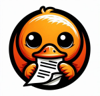

In [70]:
doc_attributes[0].images[0]

# Chunking part

In [52]:
from docling.chunking import HybridChunker
from transformers import AutoTokenizer

TOKENIZER_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL_ID)

#We intialize the chunker
chunker = HybridChunker(
    tokenizer=tokenizer,
    
    
)

#The chunker outputs an iterable object 
chunk_iter = chunker.chunk(dl_doc=docling_docs[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (584 > 512). Running this sequence through the model will result in indexing errors


Let's see what the chunks contains

In [53]:
chunks =[]
for i,chunk in enumerate(chunk_iter):
    chunks.append(chunk)
    print(f"=== {i} ===")
    print(f"chunk.text:\n{f'{chunk.text}…'!r}")

    enriched_text = chunker.contextualize(chunk=chunk)
    print(f"chunker.contextualize(chunk):\n{f'{enriched_text[:300]}…'!r}")

=== 0 ===
chunk.text:
'Christoph Auer Maksym Lysak Ahmed Nassar Michele Dolfi Nikolaos Livathinos Panos Vagenas Cesar Berrospi Ramis Matteo Omenetti Fabian Lindlbauer Kasper Dinkla Lokesh Mishra Yusik Kim Shubham Gupta Rafael Teixeira de Lima Valery Weber Lucas Morin Ingmar Meijer Viktor Kuropiatnyk Peter W. J. Staar\nAI4K Group, IBM Research R¨ uschlikon, Switzerland…'
chunker.contextualize(chunk):
'Version 1.0\nChristoph Auer Maksym Lysak Ahmed Nassar Michele Dolfi Nikolaos Livathinos Panos Vagenas Cesar Berrospi Ramis Matteo Omenetti Fabian Lindlbauer Kasper Dinkla Lokesh Mishra Yusik Kim Shubham Gupta Rafael Teixeira de Lima Valery Weber Lucas Morin Ingmar Meijer Viktor Kuropiatnyk Peter W. J…'
=== 1 ===
chunk.text:
'This technical report introduces Docling , an easy to use, self-contained, MITlicensed open-source package for PDF document conversion. It is powered by state-of-the-art specialized AI models for layout analysis (DocLayNet) and table structure recognition (TableFormer)

In [54]:
so = set()
l = []
for c in chunks:
    if c.meta.doc_items:
        for item in c.meta.doc_items:
            so.add(item.label[:])
            if item.label == "footnote":
                l.append(c)
so


{'caption', 'code', 'footnote', 'list_item', 'table', 'text'}

In [63]:
from typing import Iterable, Any
from docling.chunking import HybridChunker
from transformers import AutoTokenizer
from typing_extensions import override
from docling_core.transforms.chunker import BaseChunk
from docling_core.types.doc.labels import DocItemLabel
from docling_core.types.doc.document import DocItem, PictureItem ,PictureDescriptionData
from docling_core.types.doc.document import BoundingBox
from docling_core.transforms.chunker.hierarchical_chunker import DocChunk
from docling_core.transforms.serializer.common import create_ser_result
from docling_core.transforms.chunker.hierarchical_chunker import (
    ChunkingDocSerializer,ChunkingSerializerProvider
)
from docling_core.transforms.serializer.markdown import MarkdownTableSerializer, MarkdownPictureSerializer

#Here is my type of chunks where i gather a lot of information that will be useful after 
class CoolChunk(BaseModel):
    contextualized_chunk: str
    bboxes : list[BoundingBox]
    n_pages : list[int]
    origin: str
    labels: list[str]



#Here we define a custom picture serialization strategy which leverages picture annotations
class AnnotationPictureSerializer(MarkdownPictureSerializer):
    @override
    def serialize(self, *, item, doc_serializer, doc, **kwargs):
        
        texts : list[str] = []
        for annotation in item:
            if isinstance(annotation,PictureDescriptionData):
                texts.append(f"Picture description: {annotation.text}")
    
        text_res = "\n".join(texts)
        text_res = doc_serializer.post_process(text=text_res)
        return create_ser_result(text=text_res, span_source=item)
    
#Here we define a serializer provider that contains the table and Picture special serialization strategies
class MySerializerProvider(ChunkingSerializerProvider):
    def get_serializer(self, doc):
        return ChunkingDocSerializer(
            doc=doc,
            picture_serializer=AnnotationPictureSerializer(),
            table_serializer=MarkdownTableSerializer()
        )
    
class MyChunker:
    
    def __init__(self,
                 tokenizer_model:str = "sentence-transformers/all-MiniLM-L6-v2"
                 ):
        
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)
        self.chunker = HybridChunker(tokenizer=self.tokenizer,
                                     serializer_provider=MySerializerProvider())
    
        
    def chunk(self,
              doc: DoclingDocument,
              verbose: bool = True) -> list[CoolChunk]:
        
        def _get_items(items:list) -> list[DocItem]:
            l = []
            for item in items:
                l.append(item) 
            return l
                
        chunks = list(self.chunker.chunk(dl_doc=doc))
        chunks_lists = []
        
        for i,chunk in enumerate(chunks):
            l_items = _get_items(chunk.meta.doc_items)
            if verbose:
                print(f"========= items of chunk n°{i} extracted ==============\n ")
            chunks_lists.append(
            
                CoolChunk(
                    bboxes= [item.prov[0].bbox for item in l_items if item.prov],
                    contextualized_chunk= self.chunker.contextualize(chunk),
                    labels= [item.label[:] for item in l_items if item.label ],
                    n_pages=[item.prov[0].page_no for item in l_items if item.prov ],
                    origin= chunk.meta.origin.filename
                )
            )
            if verbose:
                print(f"========= CoolChunk n°{i} created ==============\n ")
        return chunks_lists

    def get_chunks_type(self,
                       type:str,
                       chunks: list[CoolChunk]):
        
        if type not in ["text", "picture",'table',"code"]:
            raise Exception("The provided type does not exists please choose between: 'text , 'picture', 'table'")

        type_list = []
        for c in chunks :
            if c.labels:
                for l in c.labels:
                    if  l == type:
                        type_list.append(c)
        return type_list

In [64]:
chunker  = MyChunker()
chunks = chunker.chunk(docling_docs[0])


Token indices sequence length is longer than the specified maximum sequence length for this model (806 > 512). Running this sequence through the model will result in indexing errors


========= items of chunk n°0 extracted ==============
 
========= CoolChunk n°0 created ==============
 
========= items of chunk n°1 extracted ==============
 
========= CoolChunk n°1 created ==============
 
========= items of chunk n°2 extracted ==============
 
========= CoolChunk n°2 created ==============
 
========= items of chunk n°3 extracted ==============
 
========= CoolChunk n°3 created ==============
 
========= items of chunk n°4 extracted ==============
 
========= CoolChunk n°4 created ==============
 
========= items of chunk n°5 extracted ==============
 
========= CoolChunk n°5 created ==============
 
========= items of chunk n°6 extracted ==============
 
========= CoolChunk n°6 created ==============
 
========= items of chunk n°7 extracted ==============
 
========= CoolChunk n°7 created ==============
 
========= items of chunk n°8 extracted ==============
 
========= CoolChunk n°8 created ==============
 
========= items of chunk n°9 extracted ==============
 

In [65]:
# chunker.get_chunks_type("table",chunks)
s = set()
for i in range (len(chunks)):
    if chunks[i].labels:
        for j in range(len(chunks[i].labels)):
            s.add(chunks[i].labels[j])
s

{'caption', 'code', 'footnote', 'list_item', 'table', 'text'}